### Question B, subquestion 4 (B4)

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
# import sounddevice as sd # Can be commented out if it's not installed on your system, it's not necessary for the code to run
from scipy.io import wavfile
from scipy.signal import find_peaks
import pickle
import os

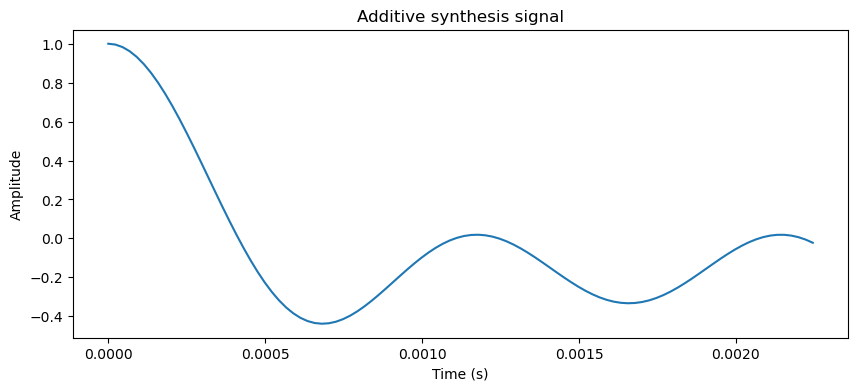

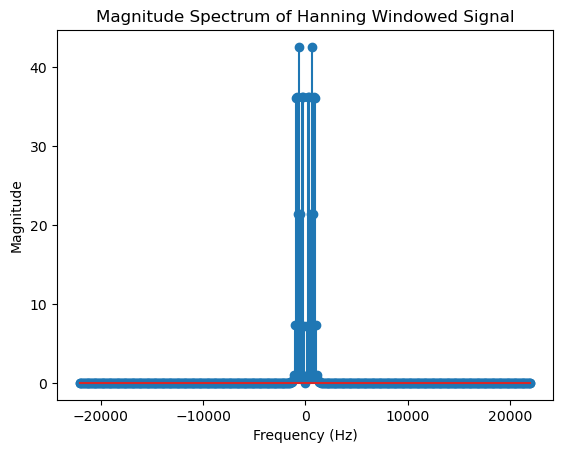

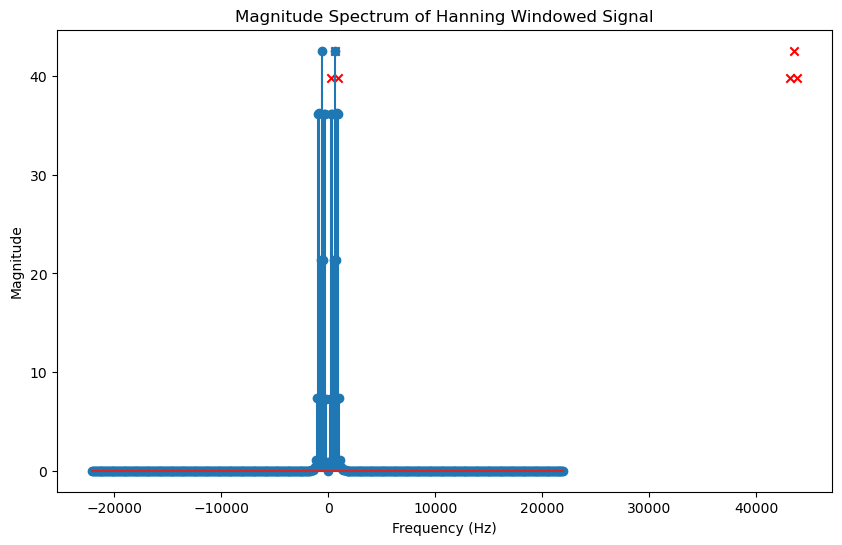

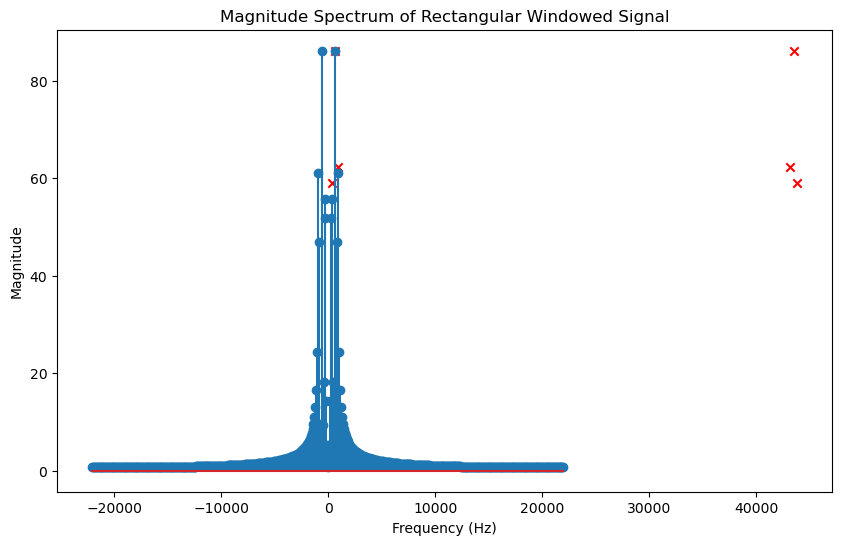

In [2]:
# In this code cell, we repeat the exact same process, as that of subquestions B1 - B3, only this time for a Hanning window instead of a rectangular window

# We import the previously stored variables from the pickle file
with open('variables.pickle', 'rb') as f:
    saved_variables = pickle.load(f)

amplitude_frequency_pairs_parabolic = saved_variables['amplitude_frequency_pairs_parabolic']
magnitude_spectrum = saved_variables['magnitude_spectrum']

# First, we define some hyperparameters for our additive synthesis model
fs = 44100 # Sampling rate
Ts = 1 / fs # Sampling period
# duration = 3 # seconds
# N = duration * fs # Number of samples
N = 512
duration = N / fs # seconds
t = np.linspace(0, duration, N, endpoint = False) # Time vector
# t = np.arange(0, duration, Ts) # Time vector

# We define the 3 fundamental frequencies
f1 = 301.4648 # Hz
f2 = 2 * f1 
f3 = 3 * f1

# All 3 signals should have unit magnitude (normalized amplitude) and no initial phase
s1 = np.cos(2 * np.pi * f1 * t)
s2 = np.cos(2 * np.pi * f2 * t)
s3 = np.cos(2 * np.pi * f3 * t)

# We want to create the new signal using additive synthesis
new_signal_B4 = s1 + s2 + s3

# We, first, normalize the signal
new_signal_B4 = new_signal_B4 / new_signal_B4.max()

# Since we want the new signal to have a length of 512 samples, we need to interpolate it
# new_t = np.linspace(0, duration, 512, endpoint = False) # Time vector for the new signal
# new_signal_interp_B4 = np.interp(new_t, t, new_signal)

# We, now, play the synthesized signal
# sd.play(new_signal_interp_B4, fs)

# We quantize the signal using 32-bit PCM (not neccessary, again can be commented out)
# new_signal_interp_B4 = np.int32(new_signal_interp * (2**31 - 1))

# We optionally save the signal in the 'Sound files' folder
if not os.path.exists('Sound files'):
    os.makedirs('Sound files')

wavfile.write('Sound files/additive_synthesis_signal_B4.wav', fs, new_signal_B4)
# NOTE: We do not intent to replay the synthesized signal in Windows Media Player, so we don't quantize it to 32-bit PCM

# We, now, plot the synthesized signal
plt.figure(figsize = (10, 4))
plt.plot(t[:100], new_signal_B4[:100]) # We plot only the first 100 samples so that it's easier to visualize the signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Additive synthesis signal')
plt.show()


# We will, now, use the Hannig window instead of the rectangular window to compute the DFT of the synthesized signal
signal_B4 = new_signal_B4 # We use the synthesized signal

# First, we define the DFT length (N)
N = len(signal_B4) # Number of samples of the signal

# We will, now, use the Hanning window instead of the rectangular window to compute the DFT of the synthesized signal
window = np.hanning(N) # Hanning window

# We, then, multiply the signal by the window
windowed_signal = signal_B4 * window

# We perform the Discrete Fourier Transform (DFT) on the windowed signal
magnitude_spectrum_B4 = np.abs(np.fft.fft(windowed_signal)) # We use np.abs to get the magnitude of the DFT (to keep only the real part)

# We get the frequency axis of the DFT (we want to keep only the positive frequencies)
freq_axis = np.fft.fftfreq(N, 1 / fs) # We use the sampling frequency to get the frequency axis

# We, finally, plot the magnitude spectrum of the signal
plt.stem(freq_axis, magnitude_spectrum_B4) # We use a stem plot to visualize the magnitude spectrum
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of Hanning Windowed Signal')
plt.show()


# We, again, need to flatten the magnitude spectrum
magnitude_spectrum_B4_flat = magnitude_spectrum_B4.flatten()

# We, then, find the peaks of the magnitude spectrum
pks, _ = find_peaks(magnitude_spectrum_B4_flat, distance = 1) # We set the distance between peaks to 1 in order to find all peaks

# We, now, get the locations (bins) and values of the peaks
locs_B4 = pks # The location of the peaks is simply the indices of the peaks
pk_values_B4 = magnitude_spectrum_B4_flat[locs_B4] # Values

# We, now, want to generate a vector (fk) that contains the frequencies of the N frequency bins of the DFT
# We do this by using the formula fk = k * fs / N (= k * 1 / Ts = k * 1 / (N * fs)), where k is the index of the frequency bin

# So, we first define the index vector (k) of the frequency bins
k = np.arange(0, N) # Index vector

# We, now, compute the frequency vector (fk) using the formula above
fk = k * fs / N

# We, now, want to convert each of the peak locations (bins) to the corresponding frequency values
# and generate a vector (pk_pairs) that contains amplitude - frequency pairs of the peaks

# To convert the peak locations (bins) to frequency values, we use the formula fk = k * fs / N
# that we implemented above
peak_frequencies_B4 = fk[locs_B4] # We get the frequency values of the peak locations

# We, then, generate the amplitude - frequency vector (list) of the peaks
# NOTE: Conventionally, we add the amplitude of the peak first, then the corresponding frequency
amplitude_frequency_pairs_B4 = []
for i in range(len(locs_B4)):
    amplitude_frequency_pairs_B4.append(pk_values_B4[i])  # Amplitude of the peak
    amplitude_frequency_pairs_B4.append(peak_frequencies_B4[i])  # Frequency of the peak


# print("Original Amplitude - Frequency pairs:\n", amplitude_frequency_pairs)

# We compare the peak frequencies with the original fundamendal frequencies, simply by printing them out

# print("\nOriginal frequencies:\n", [f1, f2, f3])
# print("\nPeak frequencies:\n", peak_frequencies_B4)


# We will, again, use the parabolic interpolation method to estimate the peak frequencies more accurately than before

# We start by initializing an empty list to store the amplitude - frequency pairs of the peaks
amplitude_frequency_pairs_parabolic_B4 = []

# We, now, perform parabolic interpolation on each peak to estimate the peak frequency more accurately
# Since parabolic interpolation requires 3 points to find local maximum, we will use the peak location
# and its two neighboring points to perform the interpolation
for loc in locs_B4:
    # We get the 3 points for parabolic interpolation
    b = loc  # Index of the peak
    a = max(b - 1, 0)  # Index of the point to the left of the peak (if it exceeds the bounds of the array, we set it to 0) 
    c = min(b + 1, len(magnitude_spectrum_B4_flat) - 1)  # Index of the point to the right of the peak (if it exceeds the bounds of the array, we set it to the last index)
    
    # We, now, get the magnitudes of the 3 points
    fa = magnitude_spectrum_B4_flat[a]
    fb = magnitude_spectrum_B4_flat[b]
    fc = magnitude_spectrum_B4_flat[c]
    
    # And, then, use the parabolic interpolation formula to estimate the peak frequency using the 3 points, as such: 
    
    # We calculate the interpolated peak location (bin) first
    interpolated_loc = 0.5 * (fa - fc) / (fa - 2 * fb + fc)
    
    # We, then, calculate the magnitude of the interpolated peak location
    interpolated_mag = fb - 0.25 * (fa - fc) * interpolated_loc
    
    # We get the interpolated frequency of the peak using the formula fk = k * fs / N
    interpolated_freq = (loc + interpolated_loc) * fs / N
    
    # And we, finally, append the amplitude - frequency pair to the list
    amplitude_frequency_pairs_parabolic_B4.append(interpolated_mag)
    amplitude_frequency_pairs_parabolic_B4.append(interpolated_freq)


# We, now, print the amplitude - frequency pairs obtained using parabolic interpolation
# print("\nAmplitude - Frequency pairs obtained WITH parabolic interpolation:\n", amplitude_frequency_pairs_parabolic_B4)

# To estimate whether the result improve or not, we print the previously obtained amplitude - frequency pairs
# print("\nAmplitude - Frequency pairs obtained WITHOUT parabolic interpolation:\n", amplitude_frequency_pairs_B4)


# We, optionally, plot the magnitude spectrum of the originally Hanning windowed signal, as well as and the interpolated signal.
plt.figure(figsize = (10, 6))
plt.stem(freq_axis, magnitude_spectrum_B4, label = 'Magnitude Spectrum of Windowed Signal')

# We, now, plot the peak frequencies of the interpolated signal
plt.scatter(amplitude_frequency_pairs_parabolic_B4[1::2], amplitude_frequency_pairs_parabolic_B4[::2], color = 'red', marker = 'x', label = 'Estimated Peaks using Parabolic Interpolation)') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of Hanning Windowed Signal')
plt.show()


# We, also optionally, plot the magnitude spectrum of the original signal, as well as the interpolated signal
plt.figure(figsize = (10, 6))
plt.stem(freq_axis, magnitude_spectrum, label = 'Magnitude Spectrum of Windowed Signal')

# We, now, plot the peak frequencies of the interpolated signal
plt.scatter(amplitude_frequency_pairs_parabolic[1::2], amplitude_frequency_pairs_parabolic[::2], color = 'red', marker = 'x', label = 'Estimated Peaks using Parabolic Interpolation)') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of Rectangular Windowed Signal')
plt.show()

# NOTE: By using a Hanning window instead of a rectangular one, we can see that the peaks are more accurate in the magnitude spectrum of the signal than before.
# The peak frequencies are closer to the original frequencies of the synthesized signal, and the amplitudes are more accurate as well.
# This is because the Hanning window tapers the signal at the edges, reducing the spectral leakage effect that we observed with the rectangular window.
# The Hanning window is also known to reduce the side lobes of the DFT, which improves the resolution of the peaks in the frequency domain.
# This is something we can see for ourselves in the plots below, as the peaks are more pronounced and accurate in the new magnitude spectrum.
